In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
from scipy.integrate import simps
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as tkr

In [2]:
#Fixed parameter values
pi = 1710; 
#beta1 =1.72;
mu =1/(83*365); 
eps =0.33;   #Youngji paper
tau = 0.8; tau = 0.8;
psi = 0.5; 
phi1, phi2 = 1/180, 1/180
h1= 0.0012; 
h2 = (1-0.74)*h1;
rho = 1/14; rhot =1/10; rhoh =1/10;
eta1= 0.71; eta2= 0.41; eta4= 0.85; eta3 = 0.46;
a = 1/3  # fixed to be 3 days  

theta = 0.5 # parameter adjusting reduced perception risk (assumed)
delta = 0.8  # proportion of tested people who quarantine/adhere to protective measures (assumed)
alpha1, alpha2 = 0.5, 0.5  # parameters which shows to which information people are more concerned

Dtilde, Btilde = 5, 5  # reactivity to information in vaccination
D, B = 1*Dtilde, 1*Btilde # reactivity to information in testing (assumed equal)
Fmax = 0.027; F10 = 0.0029; F20 = (0.9)*F10;
Tmax = 0.5; T10 = 0.03; T20 = 0.03    #Tmax is adjusted to have a good fit

# Fitted parameters
k1=  0.51
beta1=  0.67
beta2=  0.39
xi=  0.99
d1 =0.000071; d2 = 0.000073;  

In [3]:
# Initial conditions
NN = 51815808
V2_0 = 2891 #int(0.87*Data_Omicron['new_vaccinations'].iloc[0])
V1_0 = 431; #int(0.13*Data_Omicron['new_vaccinations'].iloc[0])
E2_0 = 352645 #int(0.87*20*NewCases.iloc[0])
A2_0 = 70529 #int(0.2*E2_0)
I2_0 = 282116  #int(0.8*E2_0)
IT2_0 = 17632 #int(0.87*NewCases.iloc[0])
E1_0 = 52694 #int(0.13*20*NewCases.iloc[0])  # 0.13 indicates that 13% of the total population is in the first dynamics
A1_0 = 10538 #int(0.2*E1_0)
I1_0 = 42155 #int(0.8*E1_0)
IT1_0 = 2634 #int(0.13*NewCases.iloc[0])
H_0 = 202  # ICU
R_0 = 200
Dth_0 = 15
# MV_0 = k1*((I1_0 + I2_0 + IT1_0 + IT2_0 + H_0)/NN)
# MN_0 = k1*((H_0 + d1*(I1_0+I2_0) + d2*H_0)/NN)
S2_0 = 40000000 # 0.9*(Omicron_New_Cases['people_vaccinated'].iloc[0])
S3_0 = 4365186 #0.1*(Omicron_New_Cases['people_vaccinated'].iloc[0])
S1_0 = NN-(S2_0 + S3_0 + V1_0 + V2_0 + E1_0 + E2_0 + A1_0 + A2_0 + I1_0 + I2_0 + IT1_0 + IT2_0 + H_0 + R_0)

In [4]:
#x0 = [S1_0, S2_0, S3_0, V1_0, V2_0, E1_0, E2_0, A1_0, A2_0, I1_0, I2_0, IT1_0, IT2_0, H_0, R_0, Dth_0, MV_0, MN_0]

In [5]:
def deriv(x, t, alpha2, D):
    
    S1, S2, S3, V1, V2, E1, E2, A1, A2, I1, I2, I_T1, I_T2, H, R, Dth, MV, MN  = x
    dx = np.zeros(18)
    N= S1 + S2+ S3 + V1 + V2 + E1 + E2 + A1 + A2 + I1 + I2 + I_T1 + I_T2 + H + R
    
    T1 = T10 + (Tmax -T10)*(alpha1*(D*MV)/(1+D*MV) + (1-alpha1)*(D*MN)/(1+D*MN) )
    F1 = F10 + (Fmax -F10)*(alpha1*(D*MV)/(1+D*MV) + (1-alpha1)*(D*MN)/(1+D*MN))
    
    T2 = T20 + (Tmax -T20)*(alpha2*(theta*D*MV)/(1+theta*D*MV) + (1-alpha2)*(theta*D*MN)/(1+theta*D*MN) )
    F2 = F20 + (Fmax -F20)*(alpha2*(theta*D*MV)/(1+theta*D*MV) + (1-alpha2)*(theta*D*MN)/(1+theta*D*MN))
    
    L1 = beta1*(I1 + I2 + psi*(A1 + A2) +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    L2 = beta2*(I1 + I2 + psi*(A1 + A2) +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    
    dx[0] = pi-(F1 +L1 +mu)*S1
    dx[1] = phi1*V1 -((1-eta2)*L2+F2+mu)*S2
    dx[2] = phi2*R-((1-eta3)*L2+F2+mu)*S3
    dx[3] = F1*S1-phi1*V1-(1-eta1)*L2*V1-mu*V1
    dx[4] = F2*S2+F2*S3-(1-eta4)*L2*V2-mu*V2
    dx[5] = L1*S1-(eps+mu)*E1
    dx[6] = (1-eta1)*L2*V1+(1-eta4)*L2*V2+L2*((1-eta2)*S2+(1-eta3)*S3)-(mu+eps)*E2
    dx[7] = (1-tau)*eps*E1-xi*T1*A1-(rho+mu)*A1
    dx[8] = (1-tau)*eps*E2-xi*T2*A2-(rho+mu)*A2
    dx[9] = tau*eps*E1-T1*I1-(rho+d1+mu)*I1
    dx[10] = tau*eps*E2-T2*I2-(rho+d1+mu)*I2
    dx[11] = xi*T1*A1+T1*I1-(rhot+h1+mu)*I_T1
    dx[12] = xi*T2*A2+T2*I2-(rhot+h2+mu)*I_T2
    dx[13] = h1*I_T1+h2*I_T2-rhoh*H-(d2+mu)*H
    dx[14] = rho*(A1+A2+I1+I2)+rhot*(I_T1+I_T2)+rhoh*H-(phi2+mu)*R
    dx[15] = d1*(I1+I2)+d2*H
    dx[16] = a*(k1*((I_T1+I_T2+H)/NN)-MV) #I1+I2+
    dx[17] = a*(k1*((H + d1*(I1 + I2) + d2*H)/NN)-MN)
    return dx

In [6]:
t = np.linspace(0,120,120)

In [7]:
Cum_infectious1 = np.zeros(len(t));     
Cum_hosp1 = np.zeros(len(t));          
Cum_vacc1 = np.zeros(len(t));           
Cum_tested1 = np.zeros(len(t));        
Cum_tested1_symptomatic = np.zeros(len(t)); 
Cum_death = np.zeros(len(t)); 
def CI_TC(alpha2, D): 
    
    MV_0 = k1*((I1_0 + I2_0 + IT1_0 + IT2_0 + H_0)/NN)
    MN_0 = k1*((H_0 + d1*(I1_0+I2_0) + d2*H_0)/NN)
    x0 = [S1_0, S2_0, S3_0, V1_0, V2_0, E1_0, E2_0, A1_0, A2_0, I1_0, I2_0, IT1_0, IT2_0, H_0, R_0, Dth_0, MV_0, MN_0]

    ret = odeint(deriv, x0, t, args=(alpha2, D))
    
    Cum_infectious1[0] =  I1_0 + I2_0; Cum_tested1[0] = IT1_0 + IT2_0; Cum_hosp1[0] = H_0; Cum_vacc1[0] = V1_0 + V2_0; Cum_death[0] = Dth_0 
    
    for i0 in range(1,len(t)):
        Test1_1 = T10 + (Tmax -T10)*(alpha1* np.divide(D*ret[:i0+1,16],(1+D*ret[:i0+1,16])) + (1-alpha1)* np.divide(D*ret[:i0+1,17],(1+D*ret[:i0+1,17]))) 
        Test2_1 = T20 + (Tmax -T20)*(alpha2* np.divide(theta*D*ret[:i0+1,16],(1+theta*D*ret[:i0+1,16])) + (1-alpha2)* np.divide(theta*D*ret[:i0+1,17],(1+theta*D*ret[:i0+1,17])))

        Vac1_1 = F10 + (Fmax -F10)*(alpha1*np.divide(D*ret[:i0+1,16],(1+D*ret[:i0+1,16])) + (1-alpha1)*np.divide(D*ret[:i0+1,17],(1+D*ret[:i0+1,17])))
        Vac2_1 = F20 + (Fmax -F20)*(alpha2* np.divide(theta*D*ret[:i0+1,16],(1+theta*D*ret[:i0+1,16])) + (1-alpha2)* np.divide(theta*D*ret[:i0+1,17],(1+theta*D*ret[:i0+1,17])))
        
        #Cum_infectious1[i0] = A1_0 + A2_0 + I1_0 + I2_0 + np.trapz(eps*(ret[:i0+1,5] + ret[:i0+1,6] ), t[:i0+1]) # full incidence, i.e. Incindence of asymptomatic and symptomatic
        Cum_infectious1[i0] =  I1_0 + I2_0 + np.trapz(tau*eps*(ret[:i0+1,5] + ret[:i0+1,6] ), t[:i0+1])  # Incindence of only symptomatic
        Cum_hosp1[i0] = H_0 + np.trapz(h1*ret[:i0+1,11] + h2*ret[:i0+1,12], t[:i0+1])
        Cum_vacc1[i0] = V1_0 + V2_0 + np.trapz(np.multiply(Vac1_1,ret[:i0+1,0]) + np.multiply(Vac2_1,(ret[:i0+1,1]+ret[:i0+1,2])),t[:i0+1])
        Cum_tested1[i0] = IT1_0 + IT2_0 + np.trapz(np.multiply(Test1_1,(xi*ret[:i0+1,7]+ ret[:i0+1,9])) + np.multiply(Test2_1,(xi*ret[:i0+1,8]+ ret[:i0+1,10])),t[:i0+1])
        Cum_tested1_symptomatic[i0] = IT1_0 + IT2_0 + np.trapz(np.multiply(Test1_1,ret[:i0+1,9]) + np.multiply(Test2_1,ret[:i0+1,10]),t[:i0+1])
        Cum_death[i0] =  Dth_0  +  np.trapz(d1*(ret[:i0+1,9] + ret[:i0+1,10])+ d2*ret[:i0+1,13],t[:i0+1])

    Final_CumIncidence = Cum_infectious1[-1]
    Final_CumHosp = Cum_hosp1[-1]
    Final_CumDeath = Cum_death[-1]
    #Cost over the cumulative 
    Hosp_treatment_cost = 557.3*(1/rhoh)*Cum_hosp1[-1]   # $557.3 - average daily cost of treatment in hospital, 1/rhoh - period spent in hospital before recovery,  
    Out_patient_treatment_cost = 50.5*1*(0.2*Cum_tested1_symptomatic[-1]) # $50.5 - average daily Outpatient treatment, we assumed 20% of tested people take this treatment, 1/rhot is recovery period
    Medical_treatment_cost = Hosp_treatment_cost + Out_patient_treatment_cost
    
    Vaccination_cost = 35.76*Cum_vacc1[-1]  # $35.76 is vaccination cost/person = vaccination cost ($17.89) + vaccination procedure cost($16.87) + logistic cost ($1)
    Testing_cost = 25.41*Cum_tested1[-1]  # The cost for Rapid Antigin Test (RAT) in South Korea from 20,000 to 50,000 Won. We take the averge 35,000 won == $25.41, PCR test 60000 - 80000, average = $50.56
    
    Total_cost = Medical_treatment_cost + Vaccination_cost + Testing_cost
    Cost_to_CI = Total_cost/Final_CumIncidence
   # Return the peak number of infected individuals
    return Total_cost, Final_CumIncidence

In [8]:
nn = 20;
D_values = np.linspace(0,10,nn+1);
alpha2_values = np.linspace(0,1, nn+1)

TC_Strategy0 = [[] for i in range(0,nn+1)];  CI_Strategy0 = [[] for i in range(0,nn+1)];
TC_Strategy1= [[] for i in range(0,nn+1)]; CI_Strategy1= [[] for i in range(0,nn+1)];
TC_Strategy2 = [[] for i in range(0,nn+1)]; CI_Strategy2 = [[] for i in range(0,nn+1)];

i = 0;

levels_ci = np.linspace(-50,0,nn+1)
levels_tc = np.linspace(0,60,nn+1)

Base_total_cost, Base_final_ci  = CI_TC(0, 0) 

for k1 in [0.1, 0.51, 0.9]:
    
    if k1==0.1:
                    
        for alpha2 in alpha2_values:
            
            for D in D_values:   
                
                
                
            
                               
                total_cost, final_ci = CI_TC(alpha2,D)

                change_ci = ((final_ci-Base_final_ci)/Base_final_ci)*100
                change_cost = ((total_cost-Base_total_cost)/Base_total_cost)*100

                if alpha2 == 0 and D == 0:
                    print('When k=0.1, D =0, alpha2= 0, CI change =', change_ci)
                    print('When k=0.1, D =0, alpha2= 0, TC change  =', change_cost )
                elif alpha2 == 1 and D == 10:
                    change_ci_0 = change_ci
                    change_cost_0 =  change_cost
                    print('When k=0.1, D =10, alpha2= 1, CI change =', change_ci)
                    print('When k=0.1, D =10, alpha2= 1, TC change  =', change_cost) 
                
                                                   
                TC_Strategy0[i].append(change_cost)
                CI_Strategy0[i].append(change_ci)
                
            i = i + 1;      
                
           
    elif k1 == 0.51:
        
        i=0 
        for alpha2 in alpha2_values:
                
            for D in D_values:        
                                
                total_cost, final_ci = CI_TC(alpha2, D)
                
                change_ci = ((final_ci-Base_final_ci)/Base_final_ci)*100
                change_cost = ((total_cost-Base_total_cost)/Base_total_cost)*100

                if alpha2 == 0 and D == 0:
                    print('When k=0.51, D =0, alpha2= 0, CI change =', change_ci)
                    print('When k=0.51, D =0, alpha2= 0, TC change  =', change_cost )
                elif alpha2 == 1 and D == 10:
                    
                    change_ci_1 = change_ci
                    change_cost_1 =  change_cost
                    print('When k=0.51, D =10, alpha2= 1, CI change =', change_ci)
                    print('When k=0.51, D =10, alpha2= 1, TC change  =', change_cost)
                             
                              
                TC_Strategy1[i].append(change_cost)
                CI_Strategy1[i].append(change_ci)
                
            i = i + 1;       
            
    elif k1 == 0.9:
        
        i=0
        for alpha2 in alpha2_values:   
            for D in D_values:    
                
                total_cost, final_ci = CI_TC(alpha2, D)
                change_ci = ((final_ci-Base_final_ci)/Base_final_ci)*100
                change_cost = ((total_cost-Base_total_cost)/Base_total_cost)*100    

                if alpha2 == 0 and D == 0:
                    print('When k=0.9, D =0, alpha2= 0, CI change =', change_ci)
                    print('When k=0.9, D =0, alpha2= 0, TC change  =', change_cost )
                elif alpha2 == 1 and D == 10:
                    change_ci_2 = change_ci
                    change_cost_2 =  change_cost
                    print('When k=0.9, D =10, alpha2= 1, CI change =', change_ci)
                    print('When k=0.9, D =10, alpha2= 1, TC change  =', change_cost)
                              
                TC_Strategy2[i].append(change_cost)
                CI_Strategy2[i].append(change_ci)               
               
            i = i+1

When k=0.1, D =0, alpha2= 0, CI change = 0.0
When k=0.1, D =0, alpha2= 0, TC change  = 0.0
When k=0.1, D =10, alpha2= 1, CI change = -11.122090355381262
When k=0.1, D =10, alpha2= 1, TC change  = 29.267822482794674
When k=0.51, D =0, alpha2= 0, CI change = 0.0
When k=0.51, D =0, alpha2= 0, TC change  = 0.0
When k=0.51, D =10, alpha2= 1, CI change = -34.864417549990876
When k=0.51, D =10, alpha2= 1, TC change  = 53.72361754318796
When k=0.9, D =0, alpha2= 0, CI change = 0.0
When k=0.9, D =0, alpha2= 0, TC change  = 0.0
When k=0.9, D =10, alpha2= 1, CI change = -46.15153823974916
When k=0.9, D =10, alpha2= 1, TC change  = 56.95974496320652


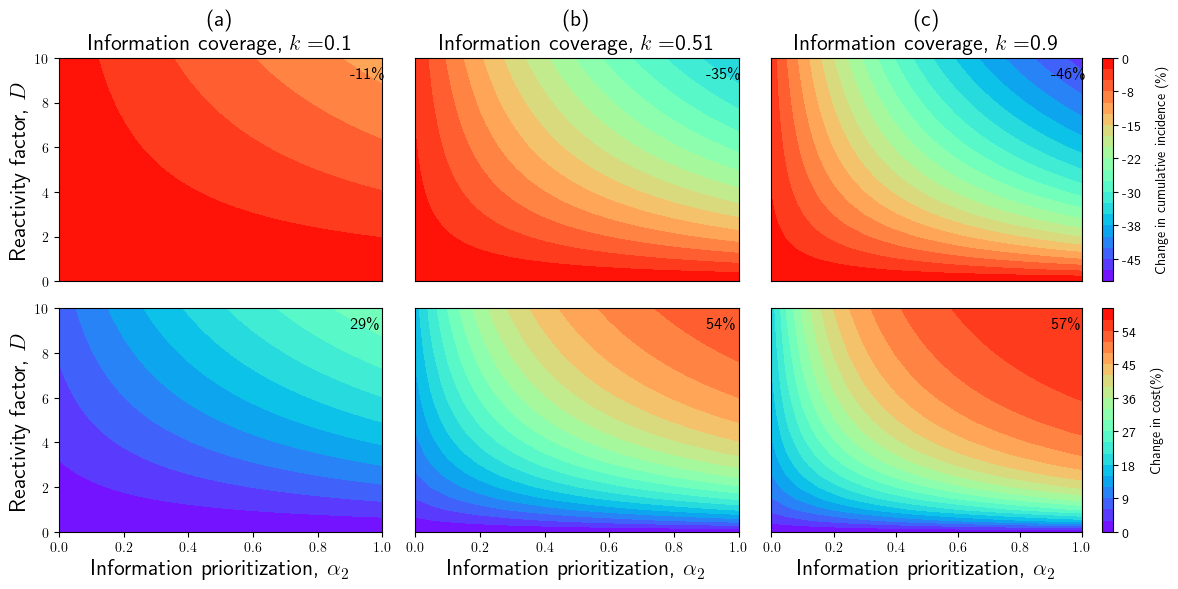

In [15]:
TC_Strategy0 = np.array(TC_Strategy0)
CI_Strategy0 = np.array(CI_Strategy0)

TC_Strategy1 = np.array(TC_Strategy1)
CI_Strategy1 = np.array(CI_Strategy1)

TC_Strategy2 = np.array(TC_Strategy2)
CI_Strategy2 = np.array(CI_Strategy2)

fig, axs = plt.subplots(2,3,figsize=(12,6),  gridspec_kw={'width_ratios': [1, 1, 1.2]})
title_lable = ['a', 'b', 'c']
info_cove = [0.1, 0.51, 0.9]
for j in [0,1,2]:
    axs[0,0].set_ylabel(r'Reactivity factor, $D$ ',fontsize=16,  fontweight="bold")
    axs[1,0].set_ylabel(r'Reactivity factor, $D$ ',fontsize=16, fontweight="bold")
    axs[1,j].set_xlabel(r'Information prioritization, $\alpha_2$',fontsize=16, fontweight="bold")
    axs[0,j].set_title(f'({title_lable[j]}) \n Information coverage, $k=${info_cove[j]}',fontsize=16, fontweight="bold")
    axs[0, j].set_xticks([])
    if j > 0:
        axs[0, j].set_yticks([])
        axs[1, j].set_yticks([])
    if j == 0:
        
        img0 = axs[0,j].contourf(alpha2_values, D_values, CI_Strategy0.T,levels=levels_ci,cmap = 'rainbow') #cmap = 'rainbow' 
        #plt.colorbar(img0,format=tkr.FormatStrFormatter('%.0f')).set_label('Change in CI', rotation= -270, labelpad=10)

        # Add contour line where percent change is zero
        # zero_contour = axs[0,j].contour(alpha2_values, D_values, CI_Strategy0.T, levels=[0], colors='black', linewidths=2, linestyles='--')
        # axs[0,j].clabel(zero_contour, fmt = "Zero Change", fontsize=10, colors='black') 

        #axs[1,ii].set_xlabel(r'Information prioritization, $\alpha_2$',fontsize=16)
        img1 = axs[1,j].contourf(alpha2_values,D_values, TC_Strategy0.T,levels=levels_tc,cmap = 'rainbow') #cmap = 'rainbow' 
        
        #plt.colorbar(img1,format=tkr.FormatStrFormatter('%.0f')).set_label('Change in TC ', rotation= -270, labelpad=10)

        # Add contour line where percent change is zero
        # zero_contour = axs[1,j].contour(alpha2_values, D_values, TC_Strategy0.T, levels=[0], colors='black', linewidths=2, linestyles='--')
        # axs[1,j].clabel(zero_contour, fmt = "Zero Change", fontsize=10, colors='black') 
    elif j == 1:            
        
        img0 = axs[0,j].contourf(alpha2_values,D_values, CI_Strategy1.T,levels=levels_ci,cmap = 'rainbow') #cmap = 'rainbow' 
        #plt.colorbar(img0,format=tkr.FormatStrFormatter('%.0f')).set_label('Change in CI', rotation= -270, labelpad=10)
        
        # Add contour line where percent change is zero
        # zero_contour = axs[0,j].contour(alpha2_values, D_values, CI_Strategy1.T, levels=[0], colors='black', linewidths=2, linestyles='--')
        # axs[0,j].clabel(zero_contour, fmt = "Zero Change", fontsize=10, colors='black') 

        #axs[1,ii].set_xlabel(r'Information prioritization, $\alpha_2$',fontsize=16)
        img1 = axs[1,j].contourf(alpha2_values,D_values, TC_Strategy1.T,levels=levels_tc,cmap = 'rainbow') #cmap = 'rainbow' 
        #plt.colorbar(img1,format=tkr.FormatStrFormatter('%.0f')).set_label('Change in TC', rotation= -270, labelpad=10)

        # Add contour line where percent change is zero
        # zero_contour = axs[1,j].contour(alpha2_values, D_values, TC_Strategy1.T, levels=[0], colors='black', linewidths=2, linestyles='--')
        # axs[1,j].clabel(zero_contour, fmt = "Zero Change", fontsize=10, colors='black') 
    elif j == 2:            
        
        img0 = axs[0,j].contourf(alpha2_values,D_values, CI_Strategy2.T,levels=levels_ci,cmap = 'rainbow') #cmap = 'rainbow' 
        plt.colorbar(img0,format=tkr.FormatStrFormatter('%.0f')).set_label('Change in cumulative incidence (\%)', rotation= -270, labelpad=10)

        # Add contour line where percent change is zero
        # zero_contour = axs[0,j].contour(alpha2_values, D_values, CI_Strategy2.T, levels=[0], colors='black', linewidths=2, linestyles='--')
        # axs[0,j].clabel(zero_contour, fmt = "Zero Change", fontsize=10, colors='black') 

        #axs[1,ii].set_xlabel(r'Information prioritization, $\alpha_2$',fontsize=16)
        img1 = axs[1,j].contourf( alpha2_values, D_values, TC_Strategy2.T,levels=levels_tc,cmap = 'rainbow') #cmap = 'rainbow' 
        plt.colorbar(img1,format=tkr.FormatStrFormatter('%.0f')).set_label('Change in cost(\%) ', rotation= -270, labelpad=10)

        # Add contour line where percent change is zero
        # zero_contour = axs[1,j].contour(alpha2_values, D_values, TC_Strategy2.T, levels=[0], colors='black', linewidths=2, linestyles='--') 

        # axs[1,j].clabel(zero_contour, fmt = "Zero Change", fontsize=10, colors='black') 

max_ci_change = [change_ci_0, change_ci_1, change_ci_2]
max_tc_change = [change_cost_0, change_cost_1, change_cost_2]

for i in range(3):
    axs[0,i].annotate(f"{max_ci_change[i]:.0f}\%", xy=(alpha2_values[-1]-0.1, D_values[-1]-0.9),   fontsize=12)
    axs[1,i].annotate(f"{max_tc_change[i]:.0f}\%", xy=(alpha2_values[-1]-0.1, D_values[-1]-0.9),   fontsize=12)

plt.tight_layout()
#plt.suptitle('Total cost per cumulative incidence with varying information coverage and priortiation by immune individuals',y =1.07, fontsize=16)
plt.savefig('Contour_percentchange.pdf', bbox_inches='tight', pad_inches=0.1, dpi =600)
plt.show()       

In [10]:
[Base_total_cost, Base_final_ci]

[1023977039.8376043, 37111698.78803756]